## Load the data

I downloaded the MNIST data as CSV from https://pjreddie.com/projects/mnist-in-csv/ .

The data has the format `label, pix-11, pix-12, pix-13, ...` so let's read everything and process it for our needs.

In [1]:
import numpy as np

# `np.uint8` would suffice to represent the greyscale value for each pixel 
# but because sklearn uses double precision internally for a lot of algorithms, 
# we're gonna use `np.float64` from the beginning.
test_data = np.genfromtxt('mnist_test.csv', delimiter=',', dtype=np.float64)
train_data = np.genfromtxt('mnist_train.csv', delimiter=',', dtype=np.float64)

# first column of each row is the digit we want to recognize later
y_test = test_data[:,0]
# the rest of the row's entries are the 28x28 greyscale values
X_test = test_data[:,1:].reshape((-1,28*28))

# same for the training data
y_train = train_data[:,0]
X_train = train_data[:,1:].reshape((-1,28*28))

# see what we end up with
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

## Feature selection

First we examine the data by plotting some digits. Maybe we can find something interesting about the features.

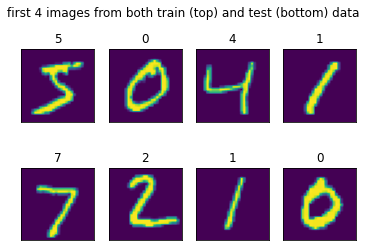

In [2]:
import matplotlib.pyplot as plt

samples = 4
f, axes = plt.subplots(2, samples)
f.suptitle(f'first {samples} images from both train (top) and test (bottom) data')

for i in range(samples):
    # top row
    axes[0][i].imshow(X_train[i].reshape(28,28))
    axes[0][i].set_title("{:.0f}".format(y_train[i]))

    # bottom row
    axes[1][i].imshow(X_test[i].reshape(28,28))
    axes[1][i].set_title("{:.0f}".format(y_test[i]))

    # get rid of axes
    axes[0][i].set_xticks(())
    axes[0][i].set_yticks(())
    axes[1][i].set_xticks(())
    axes[1][i].set_yticks(())

### We investigate which pixel carry information and which ones don't.

By looking at the mean of the training set as image we can clearly see that the pixel towards the edge of the image are more likely to be the same for every digit. Meaning these features have not much variance. One can imagine a pixel which is always black doesn't help us much when trying to distinguish digits.

> The classes in the sklearn.feature_selection module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets.
>
>VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.
>
> -- <cite>[sklearn](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-using-selectfrommodel)</cite>

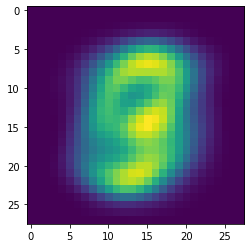

In [3]:
# visualize mean of the training set
plt.imshow(np.mean(X_train.reshape(-1,28,28), axis=0))

522 / 784 features selected


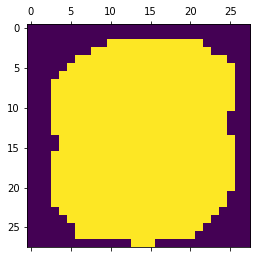

In [9]:
# lets find out more about the VarianceThreshold feature selection
# play with the threshold param and see how the image changes
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=(100))
selector.fit(X_train)
zeros = np.zeros(28*28)
# select only the pixel from our dummy image
# that had a higher variance in the training set.
selected = selector.transform(zeros.reshape(1, -1))
# mark/color the selected features
selected += 255
print('%i / 784 features selected' % selected.shape[1])
# inverse the transformation to get a 28x28 image again
selected_features = selector.inverse_transform(selected)
plt.matshow(selected_features.reshape(28,28))

## Preprocessing
> The sklearn.preprocessing package provides several common utility functions and transformer classes to change raw feature vectors into a representation that is more suitable for the downstream estimators.
>
> Standardization of datasets is a common requirement for many machine learning estimators implemented in scikit-learn; they might behave badly if the individual features do not more or less look like standard normally distributed data: Gaussian with zero mean and unit variance.
>
> -- <cite>[sklearn](https://sklearn.org/modules/preprocessing.html#preprocessing)</cite>

So let's standardize features by removing the mean and scaling to unit variance

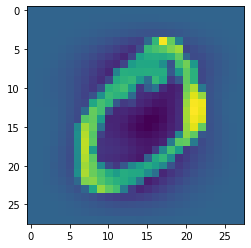

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Standardize features by removing the mean and scaling to unit variance
X_scaled = scaler.fit_transform(X_train, y_train)
# example of a scaled digit.
# let's see what the scaling did to our data
plt.imshow(X_scaled[1].reshape(28,28))

## Classify Zero digits
For now we only want to tell '0' from other digits. We need a binary classifier for zero/non-zero.

We'll try a LogisticRegression with Gradient Descent first.

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# turn target values into booleans
y_binary = y_train == 0
y_test_binary = y_test == 0

# logistic regression with 5 epochs
sgdc = SGDClassifier(loss='log', max_iter=5, verbose=2, n_jobs=1)

# select features / reduce dimensionality and
# scale selected features before classifying
SGDC = make_pipeline(VarianceThreshold(),StandardScaler(),sgdc)
SGDC.fit(X_train, y_binary)

-- Epoch 1
Norm: 280.42, NNZs: 717, Bias: -1395.863725, T: 60000, Avg. loss: 8.071034
Total training time: 0.19 seconds.
-- Epoch 2
Norm: 243.54, NNZs: 717, Bias: -1357.271930, T: 120000, Avg. loss: 2.776632
Total training time: 0.36 seconds.
-- Epoch 3
Norm: 236.30, NNZs: 717, Bias: -1333.835793, T: 180000, Avg. loss: 2.599953
Total training time: 0.54 seconds.
-- Epoch 4
Norm: 232.60, NNZs: 717, Bias: -1317.435713, T: 240000, Avg. loss: 2.542734
Total training time: 0.72 seconds.
-- Epoch 5
Norm: 229.61, NNZs: 717, Bias: -1304.977625, T: 300000, Avg. loss: 2.478315
Total training time: 0.89 seconds.


C:\Users\phil\anaconda3\envs\notebooks\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


Pipeline(steps=[('variancethreshold', VarianceThreshold()),
                ('standardscaler', StandardScaler()),
                ('sgdclassifier',
                 SGDClassifier(loss='log', max_iter=5, n_jobs=1, verbose=2))])

In [10]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# use test data only!
y_pred = SGDC.predict(X_test)

f1 = f1_score(y_test_binary, y_pred)
accuracy = accuracy_score(y_test_binary, y_pred)

# Let's see how we did.
print('accuracy: %f' %accuracy)
print('f1 score: %f' %f1)

# 5 epochs
# accuracy: 0.989000
# f1 score: 0.943299

# 197 epochs / convergence
# accuracy: 0.989300
# f1 score: 0.944703

accuracy: 0.988800
f1 score: 0.942089


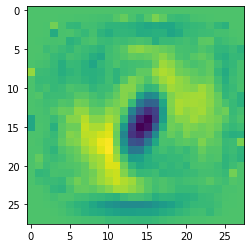

In [44]:
# lets look at the coefficients of the model
# one can definetly recognize a '0' in there
# but also some noise in outer pixel
# room for improvement!
coef = SGDC['sgdclassifier'].coef_.copy()
plt.imshow(selector.inverse_transform(coef).reshape(28,28))

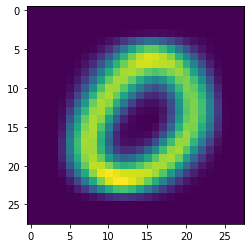

In [11]:
# mean of the digits we predicted to be zeroes
plt.imshow(np.mean(X_test[y_pred], axis=0).reshape(28,28))

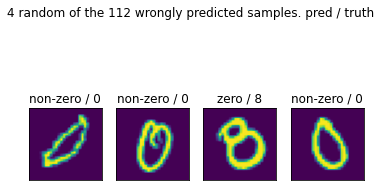

In [13]:
import matplotlib.pyplot as plt

# inspect some we predicted wrong
X_pred_wrong = X_test[np.logical_not(y_pred == y_test_binary)]

# truth
actual_digit = y_test[np.logical_not(y_pred == y_test_binary)]

# holds if we wrongly predicted a zero or wrongly predicted a non-zero
# True -> false positive, we predicted a zero but it's not
# False -> false negative, we predicted a non-zero but it actually is
y_pred_wrong = y_pred[np.logical_not(y_pred == y_test_binary)]

samples = 4
f, axes = plt.subplots(1, samples)
f.suptitle(f'{samples} random of the {len(y_pred_wrong)} wrongly predicted samples. pred / truth')

for i in range(samples):
    idx = np.random.randint(len(y_pred_wrong))
    we_predicted = "zero" if y_pred_wrong[idx] else "non-zero"
    axes[i].imshow(X_pred_wrong[idx].reshape(28,28))
    axes[i].set_title(we_predicted + " / " + "{:.0f}".format(actual_digit[idx]))

    # get rid of axes
    axes[i].set_xticks(())
    axes[i].set_yticks(())

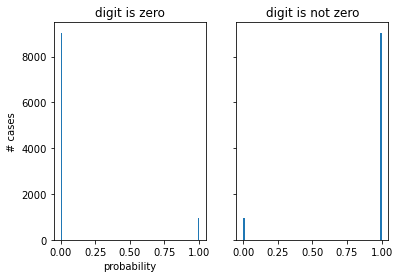

In [15]:
# let's see how sure our model is in its descision
digit_not_zero_proba = SGDC.predict_proba(X_test)[:,0]
digit_is_zero_proba = SGDC.predict_proba(X_test)[:,1]

# f, (ax1, ax2) = plt.subplots(1, 2)
ax1 = plt.subplot(121)
ax1.hist(digit_is_zero_proba, bins=100)
ax1.set_title("digit is zero")
ax1.set_ylabel("# cases")
ax1.set_xlabel("probability")
ax2 = plt.subplot(122, sharex=ax1, sharey=ax1)
plt.setp(ax2.get_yticklabels(), visible=False)
ax2.hist(digit_not_zero_proba, bins=100)
ax2.set_title("digit is not zero")
plt.show()

Looks like our model is always pretty sure about it's descision. Not too shabby considering the time spent fitting/learning. Let's move on.

## Classify all digits
Now we want to train a model that can tell if the drawn digit is a 0/1/2...8/9. We're gonna use a One-vs-rest model. Meaning a binary problem will be fit for each label individually.

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

LogRegOVR = Pipeline([
  ('feature_selection', VarianceThreshold()),
  ('feature_scaling', StandardScaler()),
#     use OVRC to parallelize the 10 binary fittings
  ('classification', OneVsRestClassifier(
      # multi_class='ovr' for One-vs-rest
      estimator=LogisticRegression(multi_class='ovr',solver='saga', random_state=42, verbose=2),
      # use all cores available
      n_jobs=-1))
], verbose=2)

LogRegOVR.fit(X_train, y_train)

[Pipeline] . (step 1 of 3) Processing feature_selection, total=   1.7s
[Pipeline] ... (step 2 of 3) Processing feature_scaling, total=   1.3s
[Pipeline] .... (step 3 of 3) Processing classification, total= 3.0min


Pipeline(steps=[('feature_selection', VarianceThreshold()),
                ('feature_scaling', StandardScaler()),
                ('classification',
                 OneVsRestClassifier(estimator=LogisticRegression(multi_class='ovr',
                                                                  random_state=42,
                                                                  solver='saga',
                                                                  verbose=2),
                                     n_jobs=-1))],
         verbose=2)

In [17]:
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

# use test data only!
y_pred = LogRegOVR.predict(X_test)

# "weighted" accounts for class imbalance by computing the average of binary metrics
# in which each class’s score is weighted by its presence in the true data sample.
f1 = f1_score(y_test, y_pred, average='weighted')
accuracy = accuracy_score(y_test, y_pred)

# Let's see how we did.
print('accuracy: %f' %accuracy)
print('f1 score: %f' %f1)

accuracy: 0.902900
f1 score: 0.902329


## Analysis
Let's get some metrics and then draw conclusions.

In [18]:
from sklearn.metrics import accuracy_score

# accuracy and f1 score for each binary classification
def accuracy_for_digit(d):
    y_digit_d = y_test == d
    # use boolean sample weight to only select the digits in question
    return accuracy_score(y_test, y_pred, sample_weight=y_digit_d)

digits = range(10)
accs = []
for digit in digits:
    accs += [accuracy_for_digit(digit)]

accs = np.array(accs)
f1s = f1_score(y_test,y_pred, average=None)

# mean of probabilities for each label (pos/neg) of each binary classification
def mean_proba_digit(d):
    # shape i.e (1013,10) .. (samples,classes)
    proba_per_class = LogRegOVR.predict_proba(X_test[y_test==d])
    pos = np.mean(proba_per_class[:,d])
    # probabilities for each class except digit d .. in other words neg proba
    proba_per_class_except_d = np.append(proba_per_class[:,:d],proba_per_class[:,d+1:],axis=1)
    # first sum for each sample the probas for not being digit d, then mean those means over all samples
    # probably 1-pos woulda been better? idk.
    # lol turns out it is exactly the same ... all the complex indexing for nothing :) 
    neg = np.mean(np.sum(proba_per_class_except_d,axis=1))
    return neg, pos

# fill np arrays
mean_proba_digits_neg = []
mean_proba_digits_pos = []
for i in digits:
    neg, pos = mean_proba_digit(i)
    mean_proba_digits_neg += [neg]
    mean_proba_digits_pos += [pos]
    
mean_neg = np.array(mean_proba_digits_neg)
mean_pos = np.array(mean_proba_digits_pos)

In [19]:
# show metrics in table
import pandas as pd
df = pd.DataFrame()

df['accuracy'] = accs
df['f1 score'] = f1s
df['mean neg proba'] = mean_neg
df['mean pos proba'] = mean_pos

df

,accuracy,f1 score,mean neg proba,mean pos proba
0,0.979592,0.954749,0.204696,0.795304
1,0.971806,0.940725,0.252513,0.747487
2,0.868217,0.897796,0.324305,0.675695
3,0.896040,0.901394,0.324101,0.675899
4,0.926680,0.903674,0.318508,0.681492
5,0.838565,0.860759,0.386155,0.613845
6,0.941545,0.930857,0.243548,0.756452
7,0.901751,0.897386,0.300156,0.699844
8,0.838809,0.853264,0.380075,0.619925
9,0.853320,0.874556,0.376253,0.623747


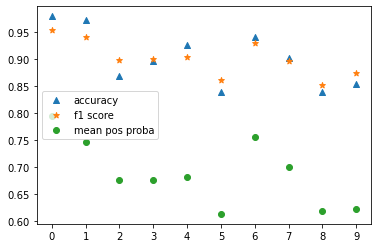

In [20]:
plt.scatter(digits,accs,label='accuracy',marker='^')
plt.scatter(digits,f1s,label='f1 score',marker='*')
plt.scatter(digits,mean_pos,label='mean pos proba',marker='o')
plt.xticks(digits)
plt.legend(loc='best')

Text(0.5, 1.0, 'wrongly predicted digits with OVR LogisticRegression')

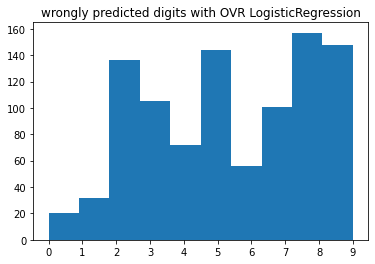

In [27]:
wrongly_pred = y_test[np.logical_not(y_pred == y_test)]
plt.hist(wrongly_pred)
plt.xticks(digits)
plt.title('wrongly predicted digits with OVR LogisticRegression')

We can see that our model has a hard time predicting the digits `8` and `9`. But it's really good at predicting digits `0` and `1`.

Text(0.5, 0.98, 'Classification vectors for all digits')

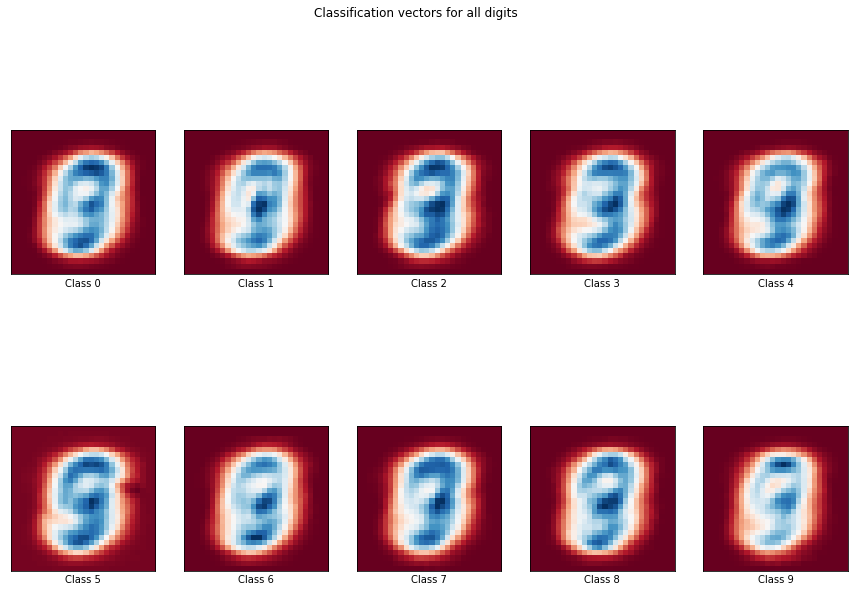

In [29]:
# OneVsRestClassifier created 10 binary LogisticRegression estimators for us
# i.e clf['classification'].estimators_

plt.figure(figsize=(15, 10))
for i in range(10):
    # get references and reverse transform coef through the pipeline
    coef = LogRegOVR['classification'].estimators_[i].coef_.copy()
    coef = LogRegOVR['feature_scaling'].inverse_transform(coef)
    coef = LogRegOVR['feature_selection'].inverse_transform(coef)
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef.reshape(28, 28), cmap=plt.cm.RdBu)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vectors for all digits')

## Detect my own handwriting

For this i drew some digits on my tablet. I created a new 24 bit greyscale canvas in GIMP and scaled down my digits onto it. Lets predict them!

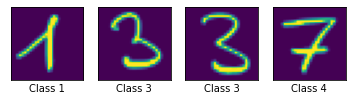

In [30]:
from PIL import Image

imgs = ["one.bmp","three1.bmp","three2.bmp","seven.bmp"]

for i in range(len(imgs)):
    l1_plot = plt.subplot(1, len(imgs), i + 1)
    img = Image.open(imgs[i])
    p = np.array(img, dtype=np.float64).reshape(1,-1)
    pred = LogRegOVR.predict(p)[0]
    l1_plot.imshow(p.reshape(28, 28))
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % pred)

Digit 7 was not predicted correctly. Very interestingly it turns out I have a different writing style for this digit. We can clearly see this by looking at the average digit 7 we trained on. It doesn't have this little bar which makes the model predict it as digit 4.

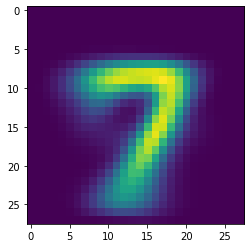

In [31]:
plt.imshow(np.mean(X_train[y_train == 7], axis=0).reshape(28,28))

## Hunt for the best accuracy
### SVMs
We will try some Support Vector Machines next. These will take much longer to fit so we'll use a higher variance threshold to reduce dimensionality a bit.

In [9]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsRestClassifier

linearSVM = Pipeline([
# use a much higher threshold this time
  ('feature_selection', VarianceThreshold(threshold=(100))),
  ('feature_scaling', StandardScaler()),
    # this requires quite a bit of installed ram
  ('classification', OneVsRestClassifier(
    # Prefer dual=False when n_samples > n_features.
      estimator=LinearSVC(dual=False,verbose=True),
    # use all cores available
      n_jobs=-1)),
], verbose=True)

linearSVM.fit(X_train, y_train)

[Pipeline] . (step 1 of 3) Processing feature_selection, total=   1.3s
[Pipeline] ... (step 2 of 3) Processing feature_scaling, total=   1.0s
[Pipeline] .... (step 3 of 3) Processing classification, total= 2.9min


Pipeline(steps=[('feature_selection', VarianceThreshold(threshold=100)),
                ('feature_scaling', StandardScaler()),
                ('classification',
                 OneVsRestClassifier(estimator=LinearSVC(dual=False,
                                                         verbose=True),
                                     n_jobs=-1))],
         verbose=True)

In [10]:
linearSVM.score(X_test,y_test)

0.9172

Accuracy is a little better than with the Logistic Regression. Let's also compare it to different kernels:

In [33]:
from sklearn.svm import SVC

deg3polySVC = Pipeline([
# use a much higher threshold this time
  ('feature_selection', VarianceThreshold(threshold=(100))),
  ('feature_scaling', StandardScaler()),
    # this requires quite a bit of installed ram
  ('classification', OneVsRestClassifier(
    # Prefer dual=False when n_samples > n_features.
      estimator=SVC(
          # If you have enough RAM available, it is recommended to set cache_size to a higher value
          cache_size=1000,
          # https://en.wikipedia.org/wiki/MNIST_database has an entry for a poly deg9 kernel SVM with a good score
          kernel='poly',
          degree=3,
          verbose=2,
          random_state=33
      ),
    # use all cores available
      n_jobs=-1)),
],verbose=True)
deg3polySVC.fit(X_train, y_train)

[Pipeline] . (step 1 of 3) Processing feature_selection, total=   1.3s
[Pipeline] ... (step 2 of 3) Processing feature_scaling, total=   1.0s
[Pipeline] .... (step 3 of 3) Processing classification, total=15.5min


Pipeline(steps=[('feature_selection', VarianceThreshold(threshold=100)),
                ('feature_scaling', StandardScaler()),
                ('classification',
                 OneVsRestClassifier(estimator=SVC(cache_size=1000,
                                                   kernel='poly',
                                                   random_state=33, verbose=2),
                                     n_jobs=-1))],
         verbose=True)

In [35]:
deg3polySVC.score(X_test,y_test) 
# 0.9715 with deg=2
# 0.9753 with deg=3, 
# 0.9678 without VarianceThreshold deg 3
# 0.9703 with deg=4 (takes time!)

0.9753

In [33]:
rbfSVC = Pipeline([
# use a much higher threshold this time
#   ('feature_selection', VarianceThreshold(threshold=(100))),
  ('feature_scaling', StandardScaler()),
    # this requires quite a bit of installed ram
  ('classification', OneVsRestClassifier(
    # Prefer dual=False when n_samples > n_features.
      estimator=SVC(
          # If you have enough RAM available, it is recommended to set cache_size to a higher value
          cache_size=1000,
          kernel='rbf',
          verbose=True
      ),
    # use all cores available
      n_jobs=-1)),
],verbose=True)
rbfSVC.fit(X_train, y_train)

[Pipeline] ... (step 1 of 2) Processing feature_scaling, total=   1.8s
[Pipeline] .... (step 2 of 2) Processing classification, total=21.1min


Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('classification',
                 OneVsRestClassifier(estimator=SVC(cache_size=1000),
                                     n_jobs=-1))],
         verbose=True)

In [34]:
rbfSVC.score(X_test,y_test)

0.9681

In [35]:
sigmoidSVC = Pipeline([
# use a much higher threshold this time
#   ('feature_selection', VarianceThreshold(threshold=(100))),
  ('feature_scaling', StandardScaler()),
    # this requires quite a bit of installed ram
  ('classification', OneVsRestClassifier(
    # Prefer dual=False when n_samples > n_features.
      estimator=SVC(
          # If you have enough RAM available, it is recommended to set cache_size to a higher value
          cache_size=1000,
          kernel='sigmoid',
          verbose=True
      ),
    # use all cores available
      n_jobs=-1)),
],verbose=True)
sigmoidSVC.fit(X_train, y_train)
sigmoidSVC.score(X_test,y_test)

[Pipeline] ... (step 1 of 2) Processing feature_scaling, total=   1.8s
[Pipeline] .... (step 2 of 2) Processing classification, total=19.1min


0.817

### Nearest Neighbors 

> Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. 
> Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.
>
> The k-neighbors classification in KNeighborsClassifier is the most commonly used technique. The optimal choice of the value k is highly data-dependent: in general a larger k suppresses the effects of noise, but makes the classification boundaries less distinct.
>In cases where the data is not uniformly sampled, radius-based neighbors classification in RadiusNeighborsClassifier can be a better choice.
> -- <cite>[sklearn](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification)</cite>

Our data is more or less uniformly distributed so lets try `KNeighborsClassifier`.

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

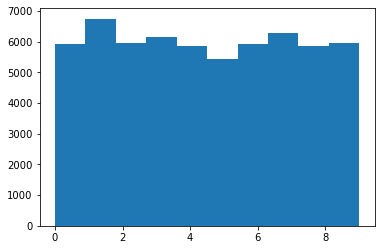

In [34]:
import matplotlib.pyplot as plt
plt.hist(y_train)

In [27]:
from sklearn.neighbors import KNeighborsClassifier
knnC = KNeighborsClassifier(n_neighbors=5,weights='distance', n_jobs=-1)
knnC.fit(X_train, y_train)
# weights k score
# distance 5 0.9691
# distance 10 0.9684
# uniform 10  0.9665
# uniform 100 0.944

KNeighborsClassifier(n_jobs=-1, weights='distance')

In [28]:
knnC.score(X_test,y_test)

0.9691

In [41]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

knnCPipe = Pipeline([
    # use a much higher threshold this time
  ('feature_selection', VarianceThreshold()),
#   ('feature_scaling', StandardScaler()),
    # this requires quite a bit of installed ram
  ('classification', KNeighborsClassifier(n_neighbors=5,weights='distance', n_jobs=-1))
    ], verbose=2)

knnCPipe.fit(X_train, y_train)

[Pipeline] . (step 1 of 2) Processing feature_selection, total=   1.6s
[Pipeline] .... (step 2 of 2) Processing classification, total=   0.1s


Pipeline(steps=[('feature_selection', VarianceThreshold()),
                ('classification',
                 KNeighborsClassifier(n_jobs=-1, weights='distance'))],
         verbose=2)

In [42]:
knnCPipe.score(X_test,y_test)

0.9691

In [44]:
from sklearn.ensemble import ExtraTreesRegressor
reg = ExtraTreesRegressor(n_estimators=100, random_state=0, n_jobs=-1, verbose=2).fit(
   X_train, y_train)
reg.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 100building tree 2 of 100building tree 3 of 100


building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.6min


building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71 of 100
building tree 72 of 100
building tree 73 of 100
building tree 74 of 100
building tree 75 of 100
building tree 76

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


0.9248230897736726

In [47]:
from sklearn.ensemble import RandomForestClassifier
reg = RandomForestClassifier(n_estimators=10000, random_state=0, n_jobs=-1, verbose=2).fit(
   X_train, y_train)
reg.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 10000building tree 2 of 10000building tree 3 of 10000
building tree 4 of 10000


building tree 5 of 10000
building tree 6 of 10000building tree 7 of 10000
building tree 8 of 10000

building tree 9 of 10000
building tree 10 of 10000
building tree 11 of 10000
building tree 12 of 10000
building tree 13 of 10000
building tree 14 of 10000
building tree 15 of 10000
building tree 16 of 10000
building tree 17 of 10000
building tree 18 of 10000
building tree 19 of 10000
building tree 20 of 10000
building tree 21 of 10000
building tree 22 of 10000
building tree 23 of 10000
building tree 24 of 10000
building tree 25 of 10000
building tree 26 of 10000
building tree 27 of 10000
building tree 28 of 10000
building tree 29 of 10000
building tree 30 of 10000
building tree 31 of 10000
building tree 32 of 10000
building tree 33 of 10000
building tree 34 of 10000
building tree 35 of 10000


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.6s


building tree 36 of 10000
building tree 37 of 10000
building tree 38 of 10000
building tree 39 of 10000
building tree 40 of 10000
building tree 41 of 10000
building tree 42 of 10000
building tree 43 of 10000
building tree 44 of 10000
building tree 45 of 10000
building tree 46 of 10000
building tree 47 of 10000
building tree 48 of 10000
building tree 49 of 10000
building tree 50 of 10000
building tree 51 of 10000
building tree 52 of 10000
building tree 53 of 10000
building tree 54 of 10000
building tree 55 of 10000
building tree 56 of 10000
building tree 57 of 10000
building tree 58 of 10000
building tree 59 of 10000
building tree 60 of 10000
building tree 61 of 10000
building tree 62 of 10000
building tree 63 of 10000
building tree 64 of 10000
building tree 65 of 10000
building tree 66 of 10000
building tree 67 of 10000
building tree 68 of 10000
building tree 69 of 10000
building tree 70 of 10000
building tree 71 of 10000
building tree 72 of 10000
building tree 73 of 10000
building tre

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.2s


building tree 155 of 10000
building tree 156 of 10000
building tree 157 of 10000
building tree 158 of 10000
building tree 159 of 10000
building tree 160 of 10000
building tree 161 of 10000
building tree 162 of 10000
building tree 163 of 10000
building tree 164 of 10000
building tree 165 of 10000
building tree 166 of 10000
building tree 167 of 10000
building tree 168 of 10000
building tree 169 of 10000
building tree 170 of 10000
building tree 171 of 10000
building tree 172 of 10000
building tree 173 of 10000
building tree 174 of 10000
building tree 175 of 10000
building tree 176 of 10000
building tree 177 of 10000
building tree 178 of 10000
building tree 179 of 10000
building tree 180 of 10000
building tree 181 of 10000
building tree 182 of 10000
building tree 183 of 10000
building tree 184 of 10000
building tree 185 of 10000
building tree 186 of 10000
building tree 187 of 10000
building tree 188 of 10000
building tree 189 of 10000
building tree 190 of 10000
building tree 191 of 10000
b

[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   42.8s


building tree 358 of 10000
building tree 359 of 10000
building tree 360 of 10000
building tree 361 of 10000
building tree 362 of 10000
building tree 363 of 10000
building tree 364 of 10000
building tree 365 of 10000
building tree 366 of 10000
building tree 367 of 10000
building tree 368 of 10000
building tree 369 of 10000
building tree 370 of 10000
building tree 371 of 10000
building tree 372 of 10000
building tree 373 of 10000
building tree 374 of 10000
building tree 375 of 10000
building tree 376 of 10000
building tree 377 of 10000
building tree 378 of 10000
building tree 379 of 10000
building tree 380 of 10000
building tree 381 of 10000
building tree 382 of 10000
building tree 383 of 10000
building tree 384 of 10000
building tree 385 of 10000
building tree 386 of 10000
building tree 387 of 10000
building tree 388 of 10000
building tree 389 of 10000
building tree 390 of 10000
building tree 391 of 10000
building tree 392 of 10000
building tree 393 of 10000
building tree 394 of 10000
b

[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.3min


building tree 640 of 10000
building tree 641 of 10000
building tree 642 of 10000
building tree 643 of 10000
building tree 644 of 10000
building tree 645 of 10000
building tree 646 of 10000
building tree 647 of 10000
building tree 648 of 10000
building tree 649 of 10000
building tree 650 of 10000
building tree 651 of 10000
building tree 652 of 10000
building tree 653 of 10000
building tree 654 of 10000
building tree 655 of 10000
building tree 656 of 10000
building tree 657 of 10000
building tree 658 of 10000
building tree 659 of 10000
building tree 660 of 10000
building tree 661 of 10000
building tree 662 of 10000
building tree 663 of 10000
building tree 664 of 10000
building tree 665 of 10000
building tree 666 of 10000
building tree 667 of 10000
building tree 668 of 10000
building tree 669 of 10000
building tree 670 of 10000
building tree 671 of 10000
building tree 672 of 10000
building tree 673 of 10000
building tree 674 of 10000
building tree 675 of 10000
building tree 676 of 10000
b

building tree 946 of 10000
building tree 947 of 10000
building tree 948 of 10000
building tree 949 of 10000
building tree 950 of 10000
building tree 951 of 10000
building tree 952 of 10000
building tree 953 of 10000
building tree 954 of 10000
building tree 955 of 10000
building tree 956 of 10000
building tree 957 of 10000
building tree 958 of 10000
building tree 959 of 10000
building tree 960 of 10000
building tree 961 of 10000
building tree 962 of 10000
building tree 963 of 10000
building tree 964 of 10000
building tree 965 of 10000
building tree 966 of 10000
building tree 967 of 10000
building tree 968 of 10000
building tree 969 of 10000
building tree 970 of 10000
building tree 971 of 10000
building tree 972 of 10000
building tree 973 of 10000
building tree 974 of 10000
building tree 975 of 10000
building tree 976 of 10000
building tree 977 of 10000
building tree 978 of 10000
building tree 979 of 10000
building tree 980 of 10000
building tree 981 of 10000
building tree 982 of 10000
b

[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.0min


building tree 1007 of 10000
building tree 1008 of 10000
building tree 1009 of 10000
building tree 1010 of 10000
building tree 1011 of 10000
building tree 1012 of 10000
building tree 1013 of 10000
building tree 1014 of 10000
building tree 1015 of 10000
building tree 1016 of 10000
building tree 1017 of 10000
building tree 1018 of 10000
building tree 1019 of 10000
building tree 1020 of 10000
building tree 1021 of 10000
building tree 1022 of 10000
building tree 1023 of 10000
building tree 1024 of 10000
building tree 1025 of 10000
building tree 1026 of 10000
building tree 1027 of 10000
building tree 1028 of 10000
building tree 1029 of 10000
building tree 1030 of 10000
building tree 1031 of 10000
building tree 1032 of 10000
building tree 1033 of 10000
building tree 1034 of 10000
building tree 1035 of 10000
building tree 1036 of 10000
building tree 1037 of 10000
building tree 1038 of 10000
building tree 1039 of 10000
building tree 1040 of 10000
building tree 1041 of 10000
building tree 1042 o

building tree 1302 of 10000
building tree 1303 of 10000
building tree 1304 of 10000
building tree 1305 of 10000
building tree 1306 of 10000
building tree 1307 of 10000
building tree 1308 of 10000
building tree 1309 of 10000
building tree 1310 of 10000
building tree 1311 of 10000
building tree 1312 of 10000
building tree 1313 of 10000
building tree 1314 of 10000
building tree 1315 of 10000
building tree 1316 of 10000
building tree 1317 of 10000
building tree 1318 of 10000
building tree 1319 of 10000
building tree 1320 of 10000
building tree 1321 of 10000
building tree 1322 of 10000
building tree 1323 of 10000
building tree 1324 of 10000
building tree 1325 of 10000
building tree 1326 of 10000
building tree 1327 of 10000
building tree 1328 of 10000
building tree 1329 of 10000
building tree 1330 of 10000
building tree 1331 of 10000
building tree 1332 of 10000
building tree 1333 of 10000
building tree 1334 of 10000
building tree 1335 of 10000
building tree 1336 of 10000
building tree 1337 o

[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  2.9min


building tree 1452 of 10000
building tree 1453 of 10000
building tree 1454 of 10000
building tree 1455 of 10000
building tree 1456 of 10000
building tree 1457 of 10000
building tree 1458 of 10000
building tree 1459 of 10000
building tree 1460 of 10000
building tree 1461 of 10000
building tree 1462 of 10000
building tree 1463 of 10000
building tree 1464 of 10000
building tree 1465 of 10000
building tree 1466 of 10000
building tree 1467 of 10000
building tree 1468 of 10000
building tree 1469 of 10000
building tree 1470 of 10000
building tree 1471 of 10000
building tree 1472 of 10000
building tree 1473 of 10000
building tree 1474 of 10000
building tree 1475 of 10000
building tree 1476 of 10000
building tree 1477 of 10000
building tree 1478 of 10000
building tree 1479 of 10000
building tree 1480 of 10000
building tree 1481 of 10000
building tree 1482 of 10000
building tree 1483 of 10000
building tree 1484 of 10000
building tree 1485 of 10000
building tree 1486 of 10000
building tree 1487 o

building tree 1746 of 10000
building tree 1747 of 10000
building tree 1748 of 10000
building tree 1749 of 10000
building tree 1750 of 10000
building tree 1751 of 10000
building tree 1752 of 10000
building tree 1753 of 10000
building tree 1754 of 10000
building tree 1755 of 10000
building tree 1756 of 10000
building tree 1757 of 10000
building tree 1758 of 10000
building tree 1759 of 10000
building tree 1760 of 10000
building tree 1761 of 10000
building tree 1762 of 10000
building tree 1763 of 10000
building tree 1764 of 10000
building tree 1765 of 10000
building tree 1766 of 10000
building tree 1767 of 10000
building tree 1768 of 10000
building tree 1769 of 10000
building tree 1770 of 10000
building tree 1771 of 10000
building tree 1772 of 10000
building tree 1773 of 10000
building tree 1774 of 10000
building tree 1775 of 10000
building tree 1776 of 10000
building tree 1777 of 10000
building tree 1778 of 10000
building tree 1779 of 10000
building tree 1780 of 10000
building tree 1781 o

[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  4.1min


building tree 1978 of 10000
building tree 1979 of 10000
building tree 1980 of 10000
building tree 1981 of 10000
building tree 1982 of 10000
building tree 1983 of 10000
building tree 1984 of 10000
building tree 1985 of 10000
building tree 1986 of 10000
building tree 1987 of 10000
building tree 1988 of 10000
building tree 1989 of 10000
building tree 1990 of 10000
building tree 1991 of 10000
building tree 1992 of 10000
building tree 1993 of 10000
building tree 1994 of 10000
building tree 1995 of 10000
building tree 1996 of 10000
building tree 1997 of 10000
building tree 1998 of 10000
building tree 1999 of 10000
building tree 2000 of 10000
building tree 2001 of 10000
building tree 2002 of 10000
building tree 2003 of 10000
building tree 2004 of 10000
building tree 2005 of 10000
building tree 2006 of 10000
building tree 2007 of 10000
building tree 2008 of 10000
building tree 2009 of 10000
building tree 2010 of 10000
building tree 2011 of 10000
building tree 2012 of 10000
building tree 2013 o

building tree 2271 of 10000
building tree 2272 of 10000
building tree 2273 of 10000
building tree 2274 of 10000
building tree 2275 of 10000
building tree 2276 of 10000
building tree 2277 of 10000
building tree 2278 of 10000
building tree 2279 of 10000
building tree 2280 of 10000
building tree 2281 of 10000
building tree 2282 of 10000
building tree 2283 of 10000
building tree 2284 of 10000
building tree 2285 of 10000
building tree 2286 of 10000
building tree 2287 of 10000
building tree 2288 of 10000
building tree 2289 of 10000
building tree 2290 of 10000
building tree 2291 of 10000
building tree 2292 of 10000
building tree 2293 of 10000
building tree 2294 of 10000
building tree 2295 of 10000
building tree 2296 of 10000
building tree 2297 of 10000
building tree 2298 of 10000
building tree 2299 of 10000
building tree 2300 of 10000
building tree 2301 of 10000
building tree 2302 of 10000
building tree 2303 of 10000
building tree 2304 of 10000
building tree 2305 of 10000
building tree 2306 o

building tree 2564 of 10000
building tree 2565 of 10000
building tree 2566 of 10000
building tree 2567 of 10000
building tree 2568 of 10000
building tree 2569 of 10000
building tree 2570 of 10000
building tree 2571 of 10000
building tree 2572 of 10000
building tree 2573 of 10000
building tree 2574 of 10000
building tree 2575 of 10000
building tree 2576 of 10000
building tree 2577 of 10000
building tree 2578 of 10000
building tree 2579 of 10000
building tree 2580 of 10000
building tree 2581 of 10000
building tree 2582 of 10000
building tree 2583 of 10000
building tree 2584 of 10000
building tree 2585 of 10000


[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  5.4min


building tree 2586 of 10000
building tree 2587 of 10000
building tree 2588 of 10000
building tree 2589 of 10000
building tree 2590 of 10000
building tree 2591 of 10000
building tree 2592 of 10000
building tree 2593 of 10000
building tree 2594 of 10000
building tree 2595 of 10000
building tree 2596 of 10000
building tree 2597 of 10000
building tree 2598 of 10000
building tree 2599 of 10000
building tree 2600 of 10000
building tree 2601 of 10000
building tree 2602 of 10000
building tree 2603 of 10000
building tree 2604 of 10000
building tree 2605 of 10000
building tree 2606 of 10000
building tree 2607 of 10000
building tree 2608 of 10000
building tree 2609 of 10000
building tree 2610 of 10000
building tree 2611 of 10000
building tree 2612 of 10000
building tree 2613 of 10000
building tree 2614 of 10000
building tree 2615 of 10000
building tree 2616 of 10000
building tree 2617 of 10000
building tree 2618 of 10000
building tree 2619 of 10000
building tree 2620 of 10000
building tree 2621 o

building tree 2880 of 10000
building tree 2881 of 10000
building tree 2882 of 10000
building tree 2883 of 10000
building tree 2884 of 10000
building tree 2885 of 10000
building tree 2886 of 10000
building tree 2887 of 10000
building tree 2888 of 10000
building tree 2889 of 10000
building tree 2890 of 10000
building tree 2891 of 10000
building tree 2892 of 10000
building tree 2893 of 10000
building tree 2894 of 10000
building tree 2895 of 10000
building tree 2896 of 10000
building tree 2897 of 10000
building tree 2898 of 10000
building tree 2899 of 10000
building tree 2900 of 10000
building tree 2901 of 10000
building tree 2902 of 10000
building tree 2903 of 10000
building tree 2904 of 10000
building tree 2905 of 10000
building tree 2906 of 10000
building tree 2907 of 10000
building tree 2908 of 10000
building tree 2909 of 10000
building tree 2910 of 10000
building tree 2911 of 10000
building tree 2912 of 10000
building tree 2913 of 10000
building tree 2914 of 10000
building tree 2915 o

building tree 3173 of 10000
building tree 3174 of 10000
building tree 3175 of 10000
building tree 3176 of 10000
building tree 3177 of 10000
building tree 3178 of 10000
building tree 3179 of 10000
building tree 3180 of 10000
building tree 3181 of 10000
building tree 3182 of 10000
building tree 3183 of 10000
building tree 3184 of 10000
building tree 3185 of 10000
building tree 3186 of 10000
building tree 3187 of 10000
building tree 3188 of 10000
building tree 3189 of 10000
building tree 3190 of 10000
building tree 3191 of 10000
building tree 3192 of 10000
building tree 3193 of 10000
building tree 3194 of 10000
building tree 3195 of 10000
building tree 3196 of 10000
building tree 3197 of 10000
building tree 3198 of 10000
building tree 3199 of 10000
building tree 3200 of 10000
building tree 3201 of 10000
building tree 3202 of 10000
building tree 3203 of 10000
building tree 3204 of 10000
building tree 3205 of 10000
building tree 3206 of 10000
building tree 3207 of 10000
building tree 3208 o

[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  6.8min


building tree 3275 of 10000
building tree 3276 of 10000
building tree 3277 of 10000
building tree 3278 of 10000
building tree 3279 of 10000
building tree 3280 of 10000
building tree 3281 of 10000
building tree 3282 of 10000
building tree 3283 of 10000
building tree 3284 of 10000
building tree 3285 of 10000
building tree 3286 of 10000
building tree 3287 of 10000
building tree 3288 of 10000
building tree 3289 of 10000
building tree 3290 of 10000
building tree 3291 of 10000
building tree 3292 of 10000
building tree 3293 of 10000
building tree 3294 of 10000
building tree 3295 of 10000
building tree 3296 of 10000
building tree 3297 of 10000
building tree 3298 of 10000
building tree 3299 of 10000
building tree 3300 of 10000
building tree 3301 of 10000
building tree 3302 of 10000
building tree 3303 of 10000
building tree 3304 of 10000
building tree 3305 of 10000
building tree 3306 of 10000
building tree 3307 of 10000
building tree 3308 of 10000
building tree 3309 of 10000
building tree 3310 o

building tree 3568 of 10000
building tree 3569 of 10000
building tree 3570 of 10000
building tree 3571 of 10000
building tree 3572 of 10000
building tree 3573 of 10000
building tree 3574 of 10000
building tree 3575 of 10000
building tree 3576 of 10000
building tree 3577 of 10000
building tree 3578 of 10000
building tree 3579 of 10000
building tree 3580 of 10000
building tree 3581 of 10000
building tree 3582 of 10000
building tree 3583 of 10000
building tree 3584 of 10000
building tree 3585 of 10000
building tree 3586 of 10000
building tree 3587 of 10000
building tree 3588 of 10000
building tree 3589 of 10000
building tree 3590 of 10000
building tree 3591 of 10000
building tree 3592 of 10000
building tree 3593 of 10000
building tree 3594 of 10000
building tree 3595 of 10000
building tree 3596 of 10000
building tree 3597 of 10000
building tree 3598 of 10000
building tree 3599 of 10000
building tree 3600 of 10000
building tree 3601 of 10000
building tree 3602 of 10000
building tree 3603 o

building tree 3863 of 10000
building tree 3864 of 10000
building tree 3865 of 10000
building tree 3866 of 10000
building tree 3867 of 10000
building tree 3868 of 10000
building tree 3869 of 10000
building tree 3870 of 10000
building tree 3871 of 10000
building tree 3872 of 10000
building tree 3873 of 10000
building tree 3874 of 10000
building tree 3875 of 10000
building tree 3876 of 10000
building tree 3877 of 10000
building tree 3878 of 10000
building tree 3879 of 10000
building tree 3880 of 10000
building tree 3881 of 10000
building tree 3882 of 10000
building tree 3883 of 10000
building tree 3884 of 10000
building tree 3885 of 10000
building tree 3886 of 10000
building tree 3887 of 10000
building tree 3888 of 10000
building tree 3889 of 10000
building tree 3890 of 10000
building tree 3891 of 10000
building tree 3892 of 10000
building tree 3893 of 10000
building tree 3894 of 10000
building tree 3895 of 10000
building tree 3896 of 10000
building tree 3897 of 10000
building tree 3898 o

[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  8.5min


building tree 4044 of 10000
building tree 4045 of 10000
building tree 4046 of 10000
building tree 4047 of 10000
building tree 4048 of 10000
building tree 4049 of 10000
building tree 4050 of 10000
building tree 4051 of 10000
building tree 4052 of 10000
building tree 4053 of 10000
building tree 4054 of 10000
building tree 4055 of 10000
building tree 4056 of 10000
building tree 4057 of 10000
building tree 4058 of 10000
building tree 4059 of 10000
building tree 4060 of 10000
building tree 4061 of 10000
building tree 4062 of 10000
building tree 4063 of 10000
building tree 4064 of 10000
building tree 4065 of 10000
building tree 4066 of 10000
building tree 4067 of 10000
building tree 4068 of 10000
building tree 4069 of 10000
building tree 4070 of 10000
building tree 4071 of 10000
building tree 4072 of 10000
building tree 4073 of 10000
building tree 4074 of 10000
building tree 4075 of 10000
building tree 4076 of 10000
building tree 4077 of 10000
building tree 4078 of 10000
building tree 4079 o

building tree 4337 of 10000
building tree 4338 of 10000
building tree 4339 of 10000
building tree 4340 of 10000
building tree 4341 of 10000
building tree 4342 of 10000
building tree 4343 of 10000
building tree 4344 of 10000
building tree 4345 of 10000
building tree 4346 of 10000
building tree 4347 of 10000
building tree 4348 of 10000
building tree 4349 of 10000
building tree 4350 of 10000
building tree 4351 of 10000
building tree 4352 of 10000
building tree 4353 of 10000
building tree 4354 of 10000
building tree 4355 of 10000
building tree 4356 of 10000
building tree 4357 of 10000
building tree 4358 of 10000
building tree 4359 of 10000
building tree 4360 of 10000
building tree 4361 of 10000
building tree 4362 of 10000
building tree 4363 of 10000
building tree 4364 of 10000
building tree 4365 of 10000
building tree 4366 of 10000
building tree 4367 of 10000
building tree 4368 of 10000
building tree 4369 of 10000
building tree 4370 of 10000
building tree 4371 of 10000
building tree 4372 o

building tree 4632 of 10000
building tree 4633 of 10000
building tree 4634 of 10000
building tree 4635 of 10000
building tree 4636 of 10000
building tree 4637 of 10000
building tree 4638 of 10000
building tree 4639 of 10000
building tree 4640 of 10000
building tree 4641 of 10000
building tree 4642 of 10000
building tree 4643 of 10000
building tree 4644 of 10000
building tree 4645 of 10000
building tree 4646 of 10000
building tree 4647 of 10000
building tree 4648 of 10000
building tree 4649 of 10000
building tree 4650 of 10000
building tree 4651 of 10000
building tree 4652 of 10000
building tree 4653 of 10000
building tree 4654 of 10000
building tree 4655 of 10000
building tree 4656 of 10000
building tree 4657 of 10000
building tree 4658 of 10000
building tree 4659 of 10000
building tree 4660 of 10000
building tree 4661 of 10000
building tree 4662 of 10000
building tree 4663 of 10000
building tree 4664 of 10000
building tree 4665 of 10000
building tree 4666 of 10000
building tree 4667 o

[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 10.3min


building tree 4896 of 10000
building tree 4897 of 10000
building tree 4898 of 10000
building tree 4899 of 10000
building tree 4900 of 10000
building tree 4901 of 10000
building tree 4902 of 10000
building tree 4903 of 10000
building tree 4904 of 10000
building tree 4905 of 10000
building tree 4906 of 10000
building tree 4907 of 10000
building tree 4908 of 10000
building tree 4909 of 10000
building tree 4910 of 10000
building tree 4911 of 10000
building tree 4912 of 10000
building tree 4913 of 10000
building tree 4914 of 10000
building tree 4915 of 10000
building tree 4916 of 10000
building tree 4917 of 10000
building tree 4918 of 10000
building tree 4919 of 10000
building tree 4920 of 10000
building tree 4921 of 10000
building tree 4922 of 10000
building tree 4923 of 10000
building tree 4924 of 10000
building tree 4925 of 10000
building tree 4926 of 10000
building tree 4927 of 10000
building tree 4928 of 10000
building tree 4929 of 10000
building tree 4930 of 10000
building tree 4931 o

building tree 5189 of 10000
building tree 5190 of 10000
building tree 5191 of 10000
building tree 5192 of 10000
building tree 5193 of 10000
building tree 5194 of 10000
building tree 5195 of 10000
building tree 5196 of 10000
building tree 5197 of 10000
building tree 5198 of 10000
building tree 5199 of 10000
building tree 5200 of 10000
building tree 5201 of 10000
building tree 5202 of 10000
building tree 5203 of 10000
building tree 5204 of 10000
building tree 5205 of 10000
building tree 5206 of 10000
building tree 5207 of 10000
building tree 5208 of 10000
building tree 5209 of 10000
building tree 5210 of 10000
building tree 5211 of 10000
building tree 5212 of 10000
building tree 5213 of 10000
building tree 5214 of 10000
building tree 5215 of 10000
building tree 5216 of 10000
building tree 5217 of 10000
building tree 5218 of 10000
building tree 5219 of 10000
building tree 5220 of 10000
building tree 5221 of 10000
building tree 5222 of 10000
building tree 5223 of 10000
building tree 5224 o

building tree 5488 of 10000
building tree 5489 of 10000
building tree 5490 of 10000
building tree 5491 of 10000
building tree 5492 of 10000
building tree 5493 of 10000
building tree 5494 of 10000
building tree 5495 of 10000
building tree 5496 of 10000
building tree 5497 of 10000
building tree 5498 of 10000
building tree 5499 of 10000
building tree 5500 of 10000
building tree 5501 of 10000
building tree 5502 of 10000building tree 5503 of 10000

building tree 5504 of 10000
building tree 5505 of 10000
building tree 5506 of 10000
building tree 5507 of 10000
building tree 5508 of 10000
building tree 5509 of 10000
building tree 5510 of 10000
building tree 5511 of 10000
building tree 5512 of 10000
building tree 5513 of 10000
building tree 5514 of 10000
building tree 5515 of 10000
building tree 5516 of 10000
building tree 5517 of 10000
building tree 5518 of 10000
building tree 5519 of 10000
building tree 5520 of 10000
building tree 5521 of 10000
building tree 5522 of 10000
building tree 5523 o

building tree 5781 of 10000
building tree 5782 of 10000
building tree 5783 of 10000
building tree 5784 of 10000
building tree 5785 of 10000
building tree 5786 of 10000
building tree 5787 of 10000
building tree 5788 of 10000
building tree 5789 of 10000
building tree 5790 of 10000
building tree 5791 of 10000
building tree 5792 of 10000
building tree 5793 of 10000
building tree 5794 of 10000
building tree 5795 of 10000
building tree 5796 of 10000
building tree 5797 of 10000
building tree 5798 of 10000
building tree 5799 of 10000
building tree 5800 of 10000
building tree 5801 of 10000
building tree 5802 of 10000
building tree 5803 of 10000
building tree 5804 of 10000
building tree 5805 of 10000
building tree 5806 of 10000
building tree 5807 of 10000
building tree 5808 of 10000
building tree 5809 of 10000
building tree 5810 of 10000
building tree 5811 of 10000
building tree 5812 of 10000
building tree 5813 of 10000
building tree 5814 of 10000
building tree 5815 of 10000
building tree 5816 o

[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 12.4min


building tree 5824 of 10000
building tree 5825 of 10000
building tree 5826 of 10000
building tree 5827 of 10000
building tree 5828 of 10000
building tree 5829 of 10000
building tree 5830 of 10000
building tree 5831 of 10000
building tree 5832 of 10000
building tree 5833 of 10000
building tree 5834 of 10000
building tree 5835 of 10000
building tree 5836 of 10000
building tree 5837 of 10000
building tree 5838 of 10000
building tree 5839 of 10000
building tree 5840 of 10000
building tree 5841 of 10000
building tree 5842 of 10000
building tree 5843 of 10000
building tree 5844 of 10000
building tree 5845 of 10000
building tree 5846 of 10000
building tree 5847 of 10000
building tree 5848 of 10000
building tree 5849 of 10000
building tree 5850 of 10000
building tree 5851 of 10000
building tree 5852 of 10000
building tree 5853 of 10000
building tree 5854 of 10000
building tree 5855 of 10000
building tree 5856 of 10000
building tree 5857 of 10000
building tree 5858 of 10000
building tree 5859 o

building tree 6118 of 10000
building tree 6119 of 10000
building tree 6120 of 10000
building tree 6121 of 10000
building tree 6122 of 10000
building tree 6123 of 10000
building tree 6124 of 10000
building tree 6125 of 10000
building tree 6126 of 10000
building tree 6127 of 10000
building tree 6128 of 10000
building tree 6129 of 10000
building tree 6130 of 10000
building tree 6131 of 10000
building tree 6132 of 10000
building tree 6133 of 10000
building tree 6134 of 10000
building tree 6135 of 10000
building tree 6136 of 10000
building tree 6137 of 10000
building tree 6138 of 10000
building tree 6139 of 10000
building tree 6140 of 10000
building tree 6141 of 10000
building tree 6142 of 10000
building tree 6143 of 10000building tree 6144 of 10000

building tree 6145 of 10000
building tree 6146 of 10000
building tree 6147 of 10000
building tree 6148 of 10000
building tree 6149 of 10000
building tree 6150 of 10000
building tree 6151 of 10000
building tree 6152 of 10000
building tree 6153 o

building tree 6410 of 10000
building tree 6411 of 10000
building tree 6412 of 10000
building tree 6413 of 10000
building tree 6414 of 10000
building tree 6415 of 10000
building tree 6416 of 10000
building tree 6417 of 10000
building tree 6418 of 10000
building tree 6419 of 10000
building tree 6420 of 10000
building tree 6421 of 10000
building tree 6422 of 10000
building tree 6423 of 10000
building tree 6424 of 10000
building tree 6425 of 10000
building tree 6426 of 10000
building tree 6427 of 10000
building tree 6428 of 10000
building tree 6429 of 10000
building tree 6430 of 10000
building tree 6431 of 10000
building tree 6432 of 10000
building tree 6433 of 10000
building tree 6434 of 10000
building tree 6435 of 10000
building tree 6436 of 10000
building tree 6437 of 10000
building tree 6438 of 10000
building tree 6439 of 10000
building tree 6440 of 10000
building tree 6441 of 10000
building tree 6442 of 10000
building tree 6443 of 10000
building tree 6444 of 10000
building tree 6445 o

building tree 6704 of 10000
building tree 6705 of 10000
building tree 6706 of 10000
building tree 6707 of 10000
building tree 6708 of 10000
building tree 6709 of 10000
building tree 6710 of 10000
building tree 6711 of 10000
building tree 6712 of 10000
building tree 6713 of 10000
building tree 6714 of 10000
building tree 6715 of 10000
building tree 6716 of 10000
building tree 6717 of 10000
building tree 6718 of 10000
building tree 6719 of 10000
building tree 6720 of 10000
building tree 6721 of 10000
building tree 6722 of 10000
building tree 6723 of 10000
building tree 6724 of 10000
building tree 6725 of 10000
building tree 6726 of 10000
building tree 6727 of 10000
building tree 6728 of 10000
building tree 6729 of 10000
building tree 6730 of 10000
building tree 6731 of 10000
building tree 6732 of 10000
building tree 6733 of 10000
building tree 6734 of 10000
building tree 6735 of 10000
building tree 6736 of 10000
building tree 6737 of 10000
building tree 6738 of 10000
building tree 6739 o

[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 14.5min



building tree 6838 of 10000
building tree 6839 of 10000
building tree 6840 of 10000
building tree 6841 of 10000
building tree 6842 of 10000
building tree 6843 of 10000
building tree 6844 of 10000
building tree 6845 of 10000
building tree 6846 of 10000
building tree 6847 of 10000
building tree 6848 of 10000
building tree 6849 of 10000
building tree 6850 of 10000
building tree 6851 of 10000
building tree 6852 of 10000
building tree 6853 of 10000
building tree 6854 of 10000
building tree 6855 of 10000
building tree 6856 of 10000
building tree 6857 of 10000
building tree 6858 of 10000
building tree 6859 of 10000
building tree 6860 of 10000
building tree 6861 of 10000
building tree 6862 of 10000
building tree 6863 of 10000
building tree 6864 of 10000
building tree 6865 of 10000
building tree 6866 of 10000
building tree 6867 of 10000
building tree 6868 of 10000
building tree 6869 of 10000
building tree 6870 of 10000
building tree 6871 of 10000
building tree 6872 of 10000
building tree 6873 

building tree 7132 of 10000
building tree 7133 of 10000
building tree 7134 of 10000
building tree 7135 of 10000
building tree 7136 of 10000
building tree 7137 of 10000
building tree 7138 of 10000
building tree 7139 of 10000
building tree 7140 of 10000
building tree 7141 of 10000
building tree 7142 of 10000
building tree 7143 of 10000
building tree 7144 of 10000
building tree 7145 of 10000
building tree 7146 of 10000
building tree 7147 of 10000
building tree 7148 of 10000
building tree 7149 of 10000
building tree 7150 of 10000
building tree 7151 of 10000
building tree 7152 of 10000
building tree 7153 of 10000
building tree 7154 of 10000
building tree 7155 of 10000
building tree 7156 of 10000
building tree 7157 of 10000
building tree 7158 of 10000
building tree 7159 of 10000
building tree 7160 of 10000
building tree 7161 of 10000
building tree 7162 of 10000
building tree 7163 of 10000
building tree 7164 of 10000
building tree 7165 of 10000
building tree 7166 of 10000
building tree 7167 o

building tree 7427 of 10000
building tree 7428 of 10000
building tree 7429 of 10000
building tree 7430 of 10000
building tree 7431 of 10000
building tree 7432 of 10000
building tree 7433 of 10000
building tree 7434 of 10000
building tree 7435 of 10000
building tree 7436 of 10000
building tree 7437 of 10000
building tree 7438 of 10000
building tree 7439 of 10000
building tree 7440 of 10000
building tree 7441 of 10000
building tree 7442 of 10000
building tree 7443 of 10000
building tree 7444 of 10000
building tree 7445 of 10000
building tree 7446 of 10000
building tree 7447 of 10000
building tree 7448 of 10000
building tree 7449 of 10000
building tree 7450 of 10000
building tree 7451 of 10000
building tree 7452 of 10000
building tree 7453 of 10000
building tree 7454 of 10000
building tree 7455 of 10000
building tree 7456 of 10000
building tree 7457 of 10000
building tree 7458 of 10000
building tree 7459 of 10000
building tree 7460 of 10000
building tree 7461 of 10000
building tree 7462 o

building tree 7721 of 10000
building tree 7722 of 10000
building tree 7723 of 10000
building tree 7724 of 10000
building tree 7725 of 10000
building tree 7726 of 10000
building tree 7727 of 10000
building tree 7728 of 10000
building tree 7729 of 10000
building tree 7730 of 10000
building tree 7731 of 10000
building tree 7732 of 10000
building tree 7733 of 10000
building tree 7734 of 10000
building tree 7735 of 10000
building tree 7736 of 10000
building tree 7737 of 10000
building tree 7738 of 10000
building tree 7739 of 10000
building tree 7740 of 10000
building tree 7741 of 10000
building tree 7742 of 10000
building tree 7743 of 10000
building tree 7744 of 10000
building tree 7745 of 10000
building tree 7746 of 10000
building tree 7747 of 10000
building tree 7748 of 10000
building tree 7749 of 10000
building tree 7750 of 10000
building tree 7751 of 10000
building tree 7752 of 10000
building tree 7753 of 10000
building tree 7754 of 10000
building tree 7755 of 10000
building tree 7756 o

[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 16.7min



building tree 7931 of 10000
building tree 7932 of 10000
building tree 7933 of 10000
building tree 7934 of 10000
building tree 7935 of 10000
building tree 7936 of 10000
building tree 7937 of 10000
building tree 7938 of 10000
building tree 7939 of 10000
building tree 7940 of 10000
building tree 7941 of 10000
building tree 7942 of 10000
building tree 7943 of 10000
building tree 7944 of 10000
building tree 7945 of 10000
building tree 7946 of 10000
building tree 7947 of 10000
building tree 7948 of 10000
building tree 7949 of 10000
building tree 7950 of 10000
building tree 7951 of 10000
building tree 7952 of 10000
building tree 7953 of 10000
building tree 7954 of 10000
building tree 7955 of 10000
building tree 7956 of 10000
building tree 7957 of 10000
building tree 7958 of 10000
building tree 7959 of 10000
building tree 7960 of 10000
building tree 7961 of 10000
building tree 7962 of 10000
building tree 7963 of 10000
building tree 7964 of 10000
building tree 7965 of 10000
building tree 7966 

building tree 8225 of 10000
building tree 8226 of 10000
building tree 8227 of 10000
building tree 8228 of 10000
building tree 8229 of 10000
building tree 8230 of 10000
building tree 8231 of 10000
building tree 8232 of 10000
building tree 8233 of 10000
building tree 8234 of 10000
building tree 8235 of 10000
building tree 8236 of 10000
building tree 8237 of 10000
building tree 8238 of 10000
building tree 8239 of 10000
building tree 8240 of 10000
building tree 8241 of 10000
building tree 8242 of 10000
building tree 8243 of 10000
building tree 8244 of 10000
building tree 8245 of 10000
building tree 8246 of 10000
building tree 8247 of 10000
building tree 8248 of 10000
building tree 8249 of 10000
building tree 8250 of 10000
building tree 8251 of 10000
building tree 8252 of 10000
building tree 8253 of 10000
building tree 8254 of 10000
building tree 8255 of 10000
building tree 8256 of 10000
building tree 8257 of 10000
building tree 8258 of 10000
building tree 8259 of 10000
building tree 8260 o

building tree 8520 of 10000
building tree 8521 of 10000
building tree 8522 of 10000
building tree 8523 of 10000
building tree 8524 of 10000
building tree 8525 of 10000
building tree 8526 of 10000
building tree 8527 of 10000
building tree 8528 of 10000
building tree 8529 of 10000
building tree 8530 of 10000
building tree 8531 of 10000
building tree 8532 of 10000
building tree 8533 of 10000
building tree 8534 of 10000
building tree 8535 of 10000
building tree 8536 of 10000
building tree 8537 of 10000
building tree 8538 of 10000
building tree 8539 of 10000
building tree 8540 of 10000
building tree 8541 of 10000
building tree 8542 of 10000
building tree 8543 of 10000
building tree 8544 of 10000
building tree 8545 of 10000
building tree 8546 of 10000
building tree 8547 of 10000
building tree 8548 of 10000
building tree 8549 of 10000
building tree 8550 of 10000
building tree 8551 of 10000
building tree 8552 of 10000
building tree 8553 of 10000
building tree 8554 of 10000
building tree 8555 o

building tree 8816 of 10000
building tree 8817 of 10000
building tree 8818 of 10000
building tree 8819 of 10000
building tree 8820 of 10000
building tree 8821 of 10000
building tree 8822 of 10000
building tree 8823 of 10000
building tree 8824 of 10000
building tree 8825 of 10000
building tree 8826 of 10000
building tree 8827 of 10000
building tree 8828 of 10000
building tree 8829 of 10000
building tree 8830 of 10000
building tree 8831 of 10000
building tree 8832 of 10000
building tree 8833 of 10000
building tree 8834 of 10000
building tree 8835 of 10000
building tree 8836 of 10000
building tree 8837 of 10000
building tree 8838 of 10000
building tree 8839 of 10000
building tree 8840 of 10000
building tree 8841 of 10000
building tree 8842 of 10000
building tree 8843 of 10000
building tree 8844 of 10000
building tree 8845 of 10000
building tree 8846 of 10000
building tree 8847 of 10000
building tree 8848 of 10000
building tree 8849 of 10000
building tree 8850 of 10000
building tree 8851 o

[Parallel(n_jobs=-1)]: Done 9097 tasks      | elapsed: 19.6min


building tree 9107 of 10000
building tree 9108 of 10000
building tree 9109 of 10000
building tree 9110 of 10000
building tree 9111 of 10000
building tree 9112 of 10000
building tree 9113 of 10000
building tree 9114 of 10000
building tree 9115 of 10000
building tree 9116 of 10000
building tree 9117 of 10000
building tree 9118 of 10000
building tree 9119 of 10000
building tree 9120 of 10000
building tree 9121 of 10000
building tree 9122 of 10000
building tree 9123 of 10000
building tree 9124 of 10000
building tree 9125 of 10000
building tree 9126 of 10000
building tree 9127 of 10000
building tree 9128 of 10000
building tree 9129 of 10000
building tree 9130 of 10000
building tree 9131 of 10000
building tree 9132 of 10000
building tree 9133 of 10000
building tree 9134 of 10000
building tree 9135 of 10000
building tree 9136 of 10000
building tree 9137 of 10000
building tree 9138 of 10000
building tree 9139 of 10000
building tree 9140 of 10000
building tree 9141 of 10000
building tree 9142 o

building tree 9402 of 10000
building tree 9403 of 10000
building tree 9404 of 10000
building tree 9405 of 10000
building tree 9406 of 10000
building tree 9407 of 10000
building tree 9408 of 10000
building tree 9409 of 10000
building tree 9410 of 10000
building tree 9411 of 10000
building tree 9412 of 10000
building tree 9413 of 10000
building tree 9414 of 10000
building tree 9415 of 10000
building tree 9416 of 10000
building tree 9417 of 10000
building tree 9418 of 10000
building tree 9419 of 10000
building tree 9420 of 10000
building tree 9421 of 10000
building tree 9422 of 10000
building tree 9423 of 10000
building tree 9424 of 10000
building tree 9425 of 10000
building tree 9426 of 10000
building tree 9427 of 10000
building tree 9428 of 10000
building tree 9429 of 10000
building tree 9430 of 10000
building tree 9431 of 10000
building tree 9432 of 10000
building tree 9433 of 10000
building tree 9434 of 10000
building tree 9435 of 10000
building tree 9436 of 10000
building tree 9437 o

building tree 9695 of 10000
building tree 9696 of 10000
building tree 9697 of 10000
building tree 9698 of 10000
building tree 9699 of 10000
building tree 9700 of 10000
building tree 9701 of 10000
building tree 9702 of 10000
building tree 9703 of 10000
building tree 9704 of 10000
building tree 9705 of 10000building tree 9706 of 10000

building tree 9707 of 10000
building tree 9708 of 10000
building tree 9709 of 10000
building tree 9710 of 10000
building tree 9711 of 10000
building tree 9712 of 10000
building tree 9713 of 10000
building tree 9714 of 10000
building tree 9715 of 10000
building tree 9716 of 10000
building tree 9717 of 10000
building tree 9718 of 10000
building tree 9719 of 10000
building tree 9720 of 10000
building tree 9721 of 10000
building tree 9722 of 10000
building tree 9723 of 10000
building tree 9724 of 10000
building tree 9725 of 10000
building tree 9726 of 10000
building tree 9727 of 10000
building tree 9728 of 10000
building tree 9729 of 10000
building tree 9730 o

building tree 9988 of 10000
building tree 9989 of 10000
building tree 9990 of 10000
building tree 9991 of 10000
building tree 9992 of 10000
building tree 9993 of 10000
building tree 9994 of 10000
building tree 9995 of 10000
building tree 9996 of 10000
building tree 9997 of 10000
building tree 9998 of 10000
building tree 9999 of 10000
building tree 10000 of 10000


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed: 21.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    0.9s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 997 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 1969 tasks      | elapsed:    5.7s
[Parallel(n_jobs=8)]: Done 2576 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done 3265 tasks      | elapsed:    9.7s
[Parallel(n_jobs=8)]: Done 4034 tasks      | elapsed:   12.3s
[Parallel(n_jobs=8)]: Done 4885 tasks      | elapsed:   14.8s
[Parallel(n_jobs=8)]: Done 5816 tasks      | elapsed:   17.6s
[Parallel(n_jobs=8)]: Done 6829 tasks      | elapsed:   20.9s
[Parallel(n_jobs=8)]: Done 7922 tasks      |

0.9719

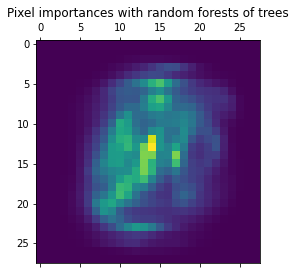

In [64]:
importances = reg.feature_importances_
importances = importances.reshape(28,28)

# Plot pixel importances
plt.matshow(importances, cmap=plt.cm.viridis)
plt.title("Pixel importances with random forests of trees")
plt.show()

In [ ]:
# conda activate notebooks